### Library

In [1]:
import pandas as pd
import numpy as np
from numpy import array

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from mape import mean_absolute_percentage_error

from IPython.display import clear_output
from pandas import ExcelWriter

import keras
from keras.models import Sequential
from keras.layers import SimpleRNN
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.models import model_from_json
from keras.layers import Dropout

from data_reshape import univariate_reshape
from Remove_Duplicate import Remove

Using TensorFlow backend.


### Data Beban Historis

In [2]:
path = r'power_dataset.xlsx'
data = pd.read_excel (path)

### Data Parameter yang akan diuji

In [3]:
path = r'RNN_hidden_neuron.xlsx'
df_par = pd.read_excel(path)

# path = r'LSTM_features.xlsx'
# df_par = pd.read_excel(path)

# path = r'LSTM_hidden_layer.xlsx'
# df_par = pd.read_excel(path)
df_par

,Unnamed: 0,dataset,feature,hidden_neuron,hidden_layer,RMSE,MAPE
0,0,1,504,168,1,0,0
1,1,2,504,168,1,0,0
2,2,3,504,168,1,0,0
3,3,4,504,168,1,0,0
4,4,5,504,168,1,0,0
...,...,...,...,...,...,...,...
115,115,26,504,672,1,0,0
116,116,27,504,672,1,0,0
117,117,28,504,672,1,0,0
118,118,29,504,672,1,0,0


Nama file saat disimpan :

In [4]:
algorithm_name = 'Revisi RNN'
# parameter_name = 'feature'
# parameter_name = 'hidden layer'
parameter_name = 'hidden neuron'

variabel_list = df_par.hidden_neuron.iloc[:]
# variabel_list = df_par.feature.iloc[:]
# variabel_list = df_par.hidden_layer.iloc[:]
unique_variabel = Remove(variabel_list)
variabel = pd.DataFrame(columns = ['variabel'])
variabel.variabel = unique_variabel
variabel

,variabel
0,168
1,336
2,504
3,672


In [5]:
# Training & Save Model
r = 1
path = r'power_dataset.xlsx'
data = pd.read_excel (path)
batas_dataset = 60

dataset = data.power.iloc[:-batas_dataset*24*7]
dataset = pd.DataFrame(dataset)
target_dum = data.power.iloc[-batas_dataset*24*7:-(batas_dataset-1)*24*7]
target_dum = target_dum.reset_index(drop=True)

# Normalize Dataset 
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

for d in range(len(variabel)) :
    
    print("Training Model {}/{}\n".format(r,len(variabel)))
    r = r+1

    in_steps = 1
    in_features = 504
    out_steps = 168
    
    train_x,train_y, _ = univariate_reshape(dataset,in_steps,in_features,out_steps,target_dum)

     ##### Parameter LSTM 
    verbose = 1
    epochs = 500
    batch_size = 50
    neuron_layer_1 = variabel.variabel.iloc[d].tolist()
    neuron_layer_2 = variabel.variabel.iloc[d].tolist()
    neuron_layer_3 = variabel.variabel.iloc[d].tolist()
    dropout_rate = 0.1

#     print("Hidden Layer : {}\n".format(variabel.variabel.iloc[d]))
    print("Hidden Layer : {}\n".format(df_par.hidden_layer.iloc[d]))

    if df_par.hidden_layer.iloc[d] == 1:
#     if variabel.variabel.iloc[d] == 1:
        # Model RNN
        model = Sequential()
        model.add(SimpleRNN(neuron_layer_1, input_shape=(in_steps, in_features), return_sequences=False))
        model.add(Dropout(dropout_rate))
        model.add(Dense(out_steps))
    elif df_par.hidden_layer.iloc[d] == 2:
#     elif variabel.variabel.iloc[d] == 2:
        # Model RNN
        model = Sequential()
        model.add(SimpleRNN(neuron_layer_1, input_shape=(in_steps, in_features), return_sequences=True))
        model.add(SimpleRNN(neuron_layer_2,input_shape=(in_steps, in_features), return_sequences=False))
        model.add(Dropout(dropout_rate))
        model.add(Dense(out_steps))
        
    elif df_par.hidden_layer.iloc[d] == 3:
#     elif variabel.variabel.iloc[d] == 3:
        # Model RNN
        model = Sequential()
        model.add(SimpleRNN(neuron_layer_1, input_shape=(in_steps, in_features), return_sequences=True))
        model.add(SimpleRNN(neuron_layer_2,input_shape=(in_steps, in_features), return_sequences=True))
        model.add(SimpleRNN(neuron_layer_3,input_shape=(in_steps, in_features)))
        model.add(Dropout(dropout_rate))
        model.add(Dense(out_steps))

    model.compile(loss='mse', optimizer='adam')
    es = keras.callbacks.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min',  restore_best_weights=True)
    history = model.fit(train_x, train_y, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[es])

    # PLOT TRAIN and Validation LOSS
    sns.set_style('white')
    sns.set_context("paper", font_scale=1.4)  
    plt.figure(figsize=(16,4))
    plt.plot(history.history['loss'], color='r', linewidth=1, marker='d', markersize=7, label='Train Loss')
    plt.plot(history.history['val_loss'], color='b',linewidth=1, marker='*',markersize=6, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation loss')
    legend = plt.legend(loc='upper right',prop={'size': 12})
    plt.savefig('{} parameter {} model number {} - loss.png'.format(parameter_name, algorithm_name,d), dpi=500)

    # serialize model to JSON
    model_json = model.to_json()
    with open("{} parameter {} model number {}.json".format(parameter_name, algorithm_name,d), "w") as json_file:
        json_file.write(model_json)

    # serialize weights to HDF5
    model.save_weights("{} parameter {} model number {}.h5".format(parameter_name, algorithm_name,d))
    
    print("")
    print("Resetting Model..")
    model.reset_states()
    
    clear_output(wait=False)

In [6]:
j = 0

for i1 in range(len(variabel)) :

    in_steps = 1
    in_features = 504

    out_steps = 168
    
    json_file = open("{} parameter {} model number {}.json".format(parameter_name, algorithm_name,i1), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model_lstm = model_from_json(loaded_model_json)

    # load weights into new model
    model_lstm.load_weights("{} parameter {} model number {}.h5".format(parameter_name, algorithm_name,i1))
    
    simpan_aktual = []
    simpan_prediksi = []
    
    for i2 in range(30):
        
        print("Testing Model {}/{}\n".format(j,len(df_par)))
        
        batas_bawah_target =  60 - i2
        batas_atas_target = batas_bawah_target-1
        target = data.power.iloc[-batas_bawah_target*24*7:-batas_atas_target*24*7]
        target = target.reset_index(drop=True)
        dataset_trg = data.power.iloc[:-batas_bawah_target*24*7]
        dataset_trg = pd.DataFrame(dataset_trg)
        
        
        # Normalize Dataset
        scaler = MinMaxScaler(feature_range=(0, 1))
        dataset_trg = scaler.fit_transform(dataset_trg)
        _ , _ ,test_sample = univariate_reshape(dataset_trg,in_steps,in_features,out_steps,target)
        
        predict = model_lstm.predict(test_sample)
        predict = scaler.inverse_transform(predict)
        
        simpan_aktual.append(target.values)
        simpan_prediksi.append(predict[0])
        
        if i2 == 29 :
            sp = np.array(simpan_prediksi)
            sp = sp.flatten()
            sa = np.array(simpan_aktual)
            sa = sa.flatten()

            simpan_total = pd.DataFrame(columns = ['Aktual','Prediksi'])
            simpan_total.Aktual = sa
            simpan_total.Prediksi = sp
            
            if i1+1 == 1 :
                sv1 = simpan_total
            if i1+1 == 2 :
                sv2 = simpan_total
            if i1+1 == 3 :
                sv3 = simpan_total
            if i1+1 == 4 :
                sv4 = simpan_total
#             writer = ExcelWriter('{} {} actual dan prediksi {} .xlsx'.format(algorithm_name,parameter_name,i1))
#             simpan_total.to_excel(writer,'Sheet1')
#             writer.save()
        
        
#         #DATA PREDICTION
#         plt.figure(figsize=(16,5))
#         plt.plot(predict[0], label = "Prediction")
#         plt.plot(target, label = "Actual Data")
#         plt.tick_params(left=False, labelleft=True) #remove ticks
#         plt.tight_layout()
#         sns.despine(top=True)
#         plt.subplots_adjust(left=0.07)
#         plt.xlabel('Time Index')
#         plt.ylabel('Power Consumption')
#         plt.legend(loc='upper right')
#         plt.title('Prediction Plot')
#         plt.savefig('{} parameter {} model number {} - Prediction Plot.png'.format(parameter_name, algorithm_name,j), dpi=500)

        #Mengisi dataframe
        df_par.RMSE.iloc[j] = np.sqrt(mean_squared_error(target,predict[0]))
        df_par.MAPE.iloc[j] = mean_absolute_percentage_error(target,predict[0])
        
#         from pandas import ExcelWriter
#         writer = ExcelWriter('{} {} Parameter Autosave Progress.xlsx'.format(algorithm_name,parameter_name))
#         df_par.to_excel(writer,'Sheet1')
#         writer.save()
        
        j = j+1
        clear_output(wait=False)

In [7]:
hn168 = df_par[df_par.hidden_neuron == 168].RMSE
hn336 = df_par[df_par.hidden_neuron == 336].RMSE
hn504 = df_par[df_par.hidden_neuron == 504].RMSE
hn672 = df_par[df_par.hidden_neuron == 672].RMSE

In [8]:
df_par

,Unnamed: 0,dataset,feature,hidden_neuron,hidden_layer,RMSE,MAPE
0,0,1,504,168,1,15.838605,5.502057
1,1,2,504,168,1,14.310742,4.821202
2,2,3,504,168,1,14.592148,5.017633
3,3,4,504,168,1,14.492324,4.960226
4,4,5,504,168,1,11.247952,3.930382
...,...,...,...,...,...,...,...
115,115,26,504,672,1,15.184405,4.999343
116,116,27,504,672,1,18.106667,5.965405
117,117,28,504,672,1,17.666431,5.842320
118,118,29,504,672,1,16.983787,5.643356


<Figure size 1152x288 with 0 Axes>

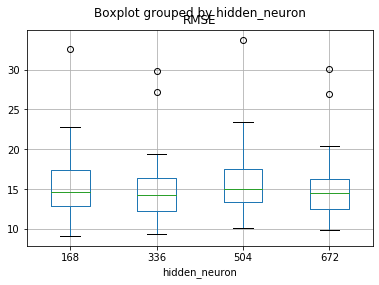

In [9]:
plt.figure(figsize=(16,4))
df_par.boxplot(by ='hidden_neuron', column =['RMSE'], grid = True) 

In [10]:
print(hn168.mean())
print(hn336.mean())
print(hn504.mean())
print(hn672.mean())

15.686585629208732
15.11608466085563
16.109505459575683
15.14891368645222


In [11]:
#Uji Kruskal Wallis 
from scipy.stats import kruskal
# compare samples
stat, p = kruskal(hn168, hn336, hn504, hn672)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Statistics=1.847, p=0.605
Same distributions (fail to reject H0)


In [12]:
writer = ExcelWriter('RNN_hidden_neuron_finish.xlsx')
df_par.to_excel(writer,'Sheet1')
writer.save()
print('complete')

complete


In [13]:
import scikit_posthocs
from scikit_posthocs import posthoc_dunn
posthoc_dunn([hn168,hn336,hn504,hn672],p_adjust='holm')

,1,2,3,4
1,-1.0,1.0,1.0,1.0
2,1.0,-1.0,1.0,1.0
3,1.0,1.0,-1.0,1.0
4,1.0,1.0,1.0,-1.0


In [14]:
path = r'RNN_hidden_neuron_finish.xlsx'
data = pd.read_excel (path)
data

,Unnamed: 0,Unnamed: 0.1,dataset,feature,hidden_neuron,hidden_layer,RMSE,MAPE
0,0,0,1,504,168,1,15.838605,5.502057
1,1,1,2,504,168,1,14.310742,4.821202
2,2,2,3,504,168,1,14.592148,5.017633
3,3,3,4,504,168,1,14.492324,4.960226
4,4,4,5,504,168,1,11.247952,3.930382
...,...,...,...,...,...,...,...,...
115,115,115,26,504,672,1,15.184405,4.999343
116,116,116,27,504,672,1,18.106667,5.965405
117,117,117,28,504,672,1,17.666431,5.842320
118,118,118,29,504,672,1,16.983787,5.643356


Text(0, 0.5, 'RMSE (MW)')

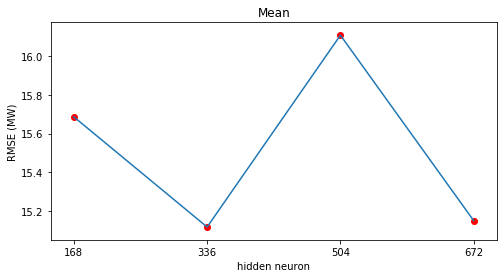

In [15]:
x1 = data[data.hidden_neuron==168].RMSE.mean()
x2 = data[data.hidden_neuron==336].RMSE.mean()
x3 = data[data.hidden_neuron==504].RMSE.mean()
x4 =data[data.hidden_neuron==672].RMSE.mean()

plt.figure(figsize=(8,4))
plt.plot([x1, x2, x3, x4])
plt.scatter('168',x1,color= 'red')
plt.scatter('336',x2,color= 'red')
plt.scatter('504',x3,color= 'red')
plt.scatter('672',x4,color= 'red')
plt.title('Mean')
plt.xlabel('hidden neuron')
plt.ylabel('RMSE (MW)')

Text(0, 0.5, 'RMSE (MW)')

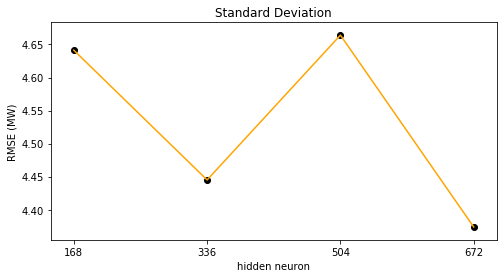

In [16]:
s1 = data[data.hidden_neuron==168].RMSE.std()
s2 = data[data.hidden_neuron==336].RMSE.std()
s3 = data[data.hidden_neuron==504].RMSE.std()
s4 =data[data.hidden_neuron==672].RMSE.std()

plt.figure(figsize=(8,4))
plt.plot([s1, s2, s3, s4],color='orange')
plt.scatter('168',s1,color= 'black')
plt.scatter('336',s2,color= 'black')
plt.scatter('504',s3,color= 'black')
plt.scatter('672',s4,color= 'black')
plt.title('Standard Deviation')
plt.xlabel('hidden neuron')
plt.ylabel('RMSE (MW)')

In [18]:
from dm_test import dm_test
a = 0;b=5040
nilai_h = int(round((np.cbrt(b-a)),0))

rt01 = dm_test(sv1.Aktual.iloc[a:b],sv2.Prediksi.iloc[a:b],sv1.Prediksi.iloc[a:b],h = nilai_h, crit="MSE")
rt02 = dm_test(sv1.Aktual.iloc[a:b],sv2.Prediksi.iloc[a:b],sv3.Prediksi.iloc[a:b],h = nilai_h, crit="MSE")
rt03 = dm_test(sv1.Aktual.iloc[a:b],sv2.Prediksi.iloc[a:b],sv4.Prediksi.iloc[a:b],h = nilai_h, crit="MSE")

print(rt01)
print(rt02)
print(rt03)


dm_return(DM=-2.6463279973239517, p_value=0.008162382377126028)
dm_return(DM=-4.407421436782681, p_value=1.0678176866119213e-05)
dm_return(DM=-0.057779871728736235, p_value=0.9539262624165986)
